<a href="https://colab.research.google.com/github/jordanlauritzen2/CRFR_Sp24_Project/blob/main/CRFR_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing Fire and Rescue Service Strain to Anticipate Emerging Service Demands

## Files Required:

The following files (all located in the 'Data' folder) are required for the notebook to run:

*   2012_2021_NewData.xlsx
*   Acutal_ValueBY_Year.csv
*   HomeType.csv
*   FIREDISTRICT.shp **
*   FIRESTATIONS.shp **
*   FIRESTATIONZONES.shp **
*   Parcel.shp **
*   Blockgroups.shp **
*   Population files *
      *   Contains 9 csv files for 2013-2021
*   Homes65+ files *
      *   Contains 9 csv files for 2013-2021
*   Blockgroups files *
      *   Contains 10 .shp files


<br>
<br>
<br>

*Entire folder is required



** For all shapefiles `.shp` the corresponding `.cpg`, `.dbf`, `.prj`, `.shx`, `.xml` are required

## Roles of Team Members

Glen:
> Words

Sophie
> Words

Jordan:
> Words

# Abstract

Words

# Introduction

Words

# Methods

Words

# Results and Discussion

this is copied from previous project

In [53]:
!pip install geopandas -q
!pip install mapclassify -q
!pip install contextily -q
!pip install cpi -q

In [54]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import mapclassify
import contextily as cx
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.linear_model import LinearRegression
from cpi import inflate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from calendar import month_abbr
from functools import reduce
import scipy as sp
from statsmodels.formula.api import ols

In [55]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
cwd = os.getcwd()
pathCRFR = cwd + '/drive/My Drive/Colab Notebooks/Math Clinic/'
pathFournier = 'Math Clinic/2024sp/CRFR/Data/'
if os.path.exists(pathCRFR + pathFournier):
    pathCRFR += pathFournier
os.listdir(pathCRFR) # lists files in the drive to check

['Acutal_ValueBY_Year.csv',
 'HomeType.csv',
 'Incident_Data_CLEAN.xlsx',
 '2012_2021_NewData.xlsx',
 'Blockgroups',
 'Population',
 'ShapeFiles',
 'Homes65+']

In [57]:
filepath = pathCRFR

## Functions

In [58]:
def pop_dfs_cleaning(df):
    df = df.iloc[:, [0,2]] # Removes all but two columns
    df = df.drop(labels = 0, axis=0) # Drop first column label
    df = df.set_index('GEO_ID') # Rename column label
    df = df.rename(index = lambda x: x[9:]) # Remove first 9 chrs.
    return df

In [59]:
def old_dfs_cleaning(df, i):
    df = df.iloc[:, [0,2,6, 26]] # Removes useless columns
    df = df.drop(labels = 0, axis=0) # Drop first column label

    # Renames columns by year
    year = old_years[i]
    df = df.rename(columns={'B11007_001E':f'Total_households_{year}', 'B11007_002E':f'Households_with_65+_{year}', 'B11007_007E':f'Households_without_65+_{year}'})

    # Rename column label and remove first 9 chrs.
    df = df.set_index('GEO_ID')
    df = df.rename(index = lambda x: x[9:])
    return df

In [60]:
square_ft2mi = 1/(5280)**2

## Importing Data

### Incident Data

In [61]:
incident_data = pd.read_excel(filepath + '2012_2021_NewData.xlsx').drop(columns = 'Jurisdiction Name')

In [62]:
# Columns with spaces rewritten with _ for calling them
incident_data = incident_data.rename(columns = {'Incident Year':'incident_year',
                                'Incident Number':'incident_number',
                                'Date of Call':'date_of_call',
                                'Day of Week':'day_of_week',
                                'Time of Call':'time_of_call',
                                'Hour of Day':'hour_of_day',
                                'Incident Type':'incident_type',
                                'Incident Type Category':'incident_type_category',
                                'Location from CAD':'location_from_cad',
                                'Response Zone':'response_zone',
                                'Station District':'station_district'})

### Actual Value Data (home values)

In [63]:
actual_value_df = pd.read_csv(filepath + 'Acutal_ValueBY_Year.csv', sep = ',')

In [64]:
actual_value_df = actual_value_df.replace('<Null>', np.nan) # Changes <Null> to NaN that pandas recognizes
actual_value_df.drop(actual_value_df.columns[[13,14]],axis=1,inplace=True) # Drops empty columns 13, 14
actual_value_df = actual_value_df.dropna() # Drops empty rows

### Home Type

SFD = Single Family Dwelling \\
SFA = Service Family Accomodation \\
MF = Multifamily dwelling \\

In [65]:
home_type_df = pd.read_csv(filepath + 'HomeType.csv', sep = ',').dropna()

### Population Tables (census data from past project)

In [66]:
# Creates list of filenames
pop_files = glob.glob(filepath + 'Population/' + '*.csv')
list_pop_dfs = []

# Reads in each file and adds to list
for filename in pop_files:
    pop_df = pd.read_csv(filename)
    list_pop_dfs.append(pop_df)

In [67]:
# For each df in that list, apply cleaning function and add to new list
clean_list_pop_dfs = []
for df in list_pop_dfs:
    clean_list_pop_dfs.append(pop_dfs_cleaning(df))

# Concatenate those dfs into one, and delete large list
pop_df = pd.concat(clean_list_pop_dfs, axis=1)
del clean_list_pop_dfs
pop_df

,pop_est_2013,pop_est_2014,pop_est_2015,pop_est_2016,pop_est_2017,pop_est_2018,pop_est_2019,pop_est_2020,pop_est_2021
GEO_ID,,,,,,,,,
080350139011,1257,1208,1170,1346,1566,1235,1416,NaN,NaN
080350139012,1536,1670,1737,1638,2192,2298,2344,NaN,NaN
080350139013,1334,1660,1744,2166,1918,1841,1980,NaN,NaN
080350139014,2234,2266,2355,2360,2022,2154,2067,NaN,NaN
080350139041,1477,1742,1718,1464,1507,1487,1457,1349,1416
...,...,...,...,...,...,...,...,...,...
080350144104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1199,1359
080350144105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194,598
080350144106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1449,1198


In [68]:
pop_df.reset_index(inplace=True)
pop_df = pd.wide_to_long(pop_df, stubnames='pop_est_', i='GEO_ID' , j='year')
pop_df.reset_index(inplace=True)
pop_df = pop_df.rename(columns={'GEO_ID':'GEOID', 'pop_est_':'pop_est'})
pop_df = pop_df.set_index(['GEOID', 'year'])
pop_df

,,pop_est
GEOID,year,
080350139011,2013,1257
080350139012,2013,1536
080350139013,2013,1334
080350139014,2013,2234
080350139041,2013,1477
...,...,...
080350144104,2021,1359
080350144105,2021,598
080350144106,2021,1198


### Age Demographics (census data from past project)

In [69]:
# Creates list of filenames
old_files = glob.glob(filepath + 'Homes65+/' + '*.csv')
list_old_dfs = []
old_years = []

# Reads in each file and adds to list
for filename in old_files:
  old_df = pd.read_csv(filename)
  list_old_dfs.append(old_df)
  old_years.append(filename[-20:-16]) # saves the year (string) from the filename to a list of years

In [70]:
# For each df in that list, apply cleaning function and add to new list
clean_list_old_dfs = []
for i, df in enumerate(list_old_dfs):
  clean_list_old_dfs.append(old_dfs_cleaning(df, i))

# Concatenate those dfs into one, and delete large list
old_df = pd.concat(clean_list_old_dfs, axis=1)
del clean_list_old_dfs
old_df

,Total_households_2013,Households_with_65+_2013,Households_without_65+_2013,Total_households_2015,Households_with_65+_2015,Households_without_65+_2015,Total_households_2020,Households_with_65+_2020,Households_without_65+_2020,Total_households_2018,...,Households_without_65+_2019,Total_households_2021,Households_with_65+_2021,Households_without_65+_2021,Total_households_2014,Households_with_65+_2014,Households_without_65+_2014,Total_households_2017,Households_with_65+_2017,Households_without_65+_2017
GEO_ID,,,,,,,,,,,,,,,,,,,,,
080350139011,732,137,595,739,171,568,NaN,NaN,NaN,691,...,614,NaN,NaN,NaN,705,154,551,951,211,740
080350139012,714,224,490,710,250,460,NaN,NaN,NaN,714,...,535,NaN,NaN,NaN,696,272,424,701,213,488
080350139013,522,274,248,668,321,347,NaN,NaN,NaN,764,...,373,NaN,NaN,NaN,620,295,325,796,413,383
080350139014,657,28,629,728,67,661,NaN,NaN,NaN,670,...,594,NaN,NaN,NaN,658,17,641,631,46,585
080350139041,589,64,525,637,75,562,550,76,474,552,...,495,582,71,511,638,67,571,566,73,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
080350144104,NaN,NaN,NaN,NaN,NaN,NaN,387,113,274,NaN,...,NaN,438,141,297,NaN,NaN,NaN,NaN,NaN,NaN
080350144105,NaN,NaN,NaN,NaN,NaN,NaN,81,0,81,NaN,...,NaN,298,0,298,NaN,NaN,NaN,NaN,NaN,NaN
080350144106,NaN,NaN,NaN,NaN,NaN,NaN,502,106,396,NaN,...,NaN,490,108,382,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
old_df.reset_index(inplace=True)
old_df = pd.wide_to_long(old_df, stubnames=['Total_households_', 'Households_with_65+_', 'Households_without_65+_'], i='GEO_ID', j='year')
old_df.reset_index(inplace=True)
old_df = old_df.rename(columns={'GEO_ID':'GEOID', 'Total_households_':'Total_households', 'Households_with_65+_':'Households_with_65+', 'Households_without_65+_':'Households_without_65+'})
old_df = old_df.set_index(['GEOID', 'year'])
old_df['Total_households'] = pd.to_numeric(old_df['Total_households'])
old_df['Households_with_65+'] = pd.to_numeric(old_df['Households_with_65+'])
old_df['Percent_households_with_65+'] = old_df['Households_with_65+']/old_df['Total_households']*100
old_df

,,Total_households,Households_with_65+,Households_without_65+,Percent_households_with_65+
GEOID,year,,,,
080350139011,2013,732.0,137.0,595,18.715847
080350139012,2013,714.0,224.0,490,31.372549
080350139013,2013,522.0,274.0,248,52.490421
080350139014,2013,657.0,28.0,629,4.261796
080350139041,2013,589.0,64.0,525,10.865874
...,...,...,...,...,...
080350144104,2017,NaN,NaN,NaN,NaN
080350144105,2017,NaN,NaN,NaN,NaN
080350144106,2017,NaN,NaN,NaN,NaN


### Shape Files

In [72]:
bg_files = glob.glob(filepath + 'Blockgroups/' + '*.shp')
list_bgs = []
bgs_years = []
for filename in bg_files:
   bg_shp = gpd.read_file(filename)
   list_bgs.append(bg_shp)
   bgs_years.append(filename[-18:-14]) # keeps year from file name)

In [73]:
fs_zones_gdf = gpd.read_file(filepath + 'ShapeFiles/FIRESTATIONZONES.shp')
firestations_gdf = gpd.read_file(filepath + 'ShapeFiles/FIRESTATIONS.shp')
fs_districts_gdf = gpd.read_file(filepath + 'ShapeFiles/FIREDISTRICT.shp')

In [74]:
parcels_douglas_gdf = gpd.read_file(filepath + 'ShapeFiles/Parcel.shp')

In [75]:
fs_zones_gdf = fs_zones_gdf.to_crs(epsg=4326) # reprojecting to all be the same
firestations_gdf = firestations_gdf.to_crs(epsg=4326)
fs_districts_gdf = fs_districts_gdf.to_crs(epsg=4326)
parcels_douglas_gdf = parcels_douglas_gdf.to_crs(epsg=4326)
for shp in list_bgs:
  if shp.crs != "epsg:4326":
    shp = shp.to_crs(epsg=4326)

In [76]:
parcels_fsarea = gpd.overlay(parcels_douglas_gdf, fs_districts_gdf, how="intersection") #cutting file down to only fire station area

In [77]:
parcels_fsarea = parcels_fsarea.rename(columns={'PARCEL_SPN': 'SPN'}) # renaming columns to be able to join
parcels_fsarea = parcels_fsarea.join(actual_value_df, lsuffix='_par', rsuffix='_val') # joining home values to parcel shape file
home_type_df = home_type_df.rename(columns = {'STATE_PARC': 'SPN_par'})
home_type_df = home_type_df.rename(columns = {'OBJECTID': 'OBJECTID_home'})
parcels_fsarea = parcels_fsarea.join(home_type_df, lsuffix='_2', rsuffix='_home') # joining home type to parcel shape file

In [78]:
parcels_fsarea.head()

,OBJECTID,SPN_par_2,DEEDED_ARE,CALC_AREA,LEGAL_DESC,PARCEL_NAM,BLOCK_NO,SHAPESTAre,FIREDIST,SOURCE,...,AV_2017,AV_2018,AV_2019,AV_2020,AV_2021,OBJECTID_home,SPN_par_home,Bldg_Type,Housing_Code,Occupany
0,36,250501101053,0.240,0.238267,LOT 25 BLOCK 3 THE WOODLANDS FILING 12 0.24 AM/L,25,3,10378.916504,CASTLE ROCK FD,DOUGLAS,...,527102,527102,665138,665138,614156,1.0,250501101053,Residential,SFD,3.02
1,41,250521006044,0.138,0.136932,LOT 22 BLK 2 DAWSON RIDGE #11 .138 AM/L,22,2,5964.757324,CASTLE ROCK FD,DOUGLAS,...,1800000,1800000,1883520,1883520,2077258,NaN,NaN,NaN,NaN,NaN
2,44,250534005006,5.010,5.007581,LOT 151 BELL MOUNTAIN RANCH #1B 5.010 AM/L,151,0,218130.220703,CASTLE ROCK FD,DOUGLAS,...,854,854,894,894,931,3.0,250534005006,Residential,SFD,3.02
3,118,250708412045,0.092,0.095548,LOT 22 BLOCK 3 CASTLEWOOD RANCH FLG 1 PARCEL 1...,22,3,4162.078125,CASTLE ROCK FD,DOUGLAS,...,561578,561578,996768,996768,1037026,4.0,250708412045,Residential,SFA,2.50
4,119,250709301020,0.298,0.295247,LOT 23 BLOCK 1 CASTLEWOOD RANCH FILING #2 PARC...,23,1,12860.937500,CASTLE ROCK FD,DOUGLAS,...,1198144,1198144,1320898,1320898,1416166,5.0,250709301020,Residential,SFD,3.02


In [79]:
geometry = gpd.points_from_xy(incident_data.Longitude, incident_data.Latitude, crs="EPSG:4326") # creating points for each call for service
incidents_gdf = gpd.GeoDataFrame(incident_data,crs="EPSG:4326", geometry=geometry) # creating geodataframe for incident data

In [80]:
incidents_homevalues = incidents_gdf.sjoin(parcels_fsarea, how='left') #spatial join, adding parcel information to each call point

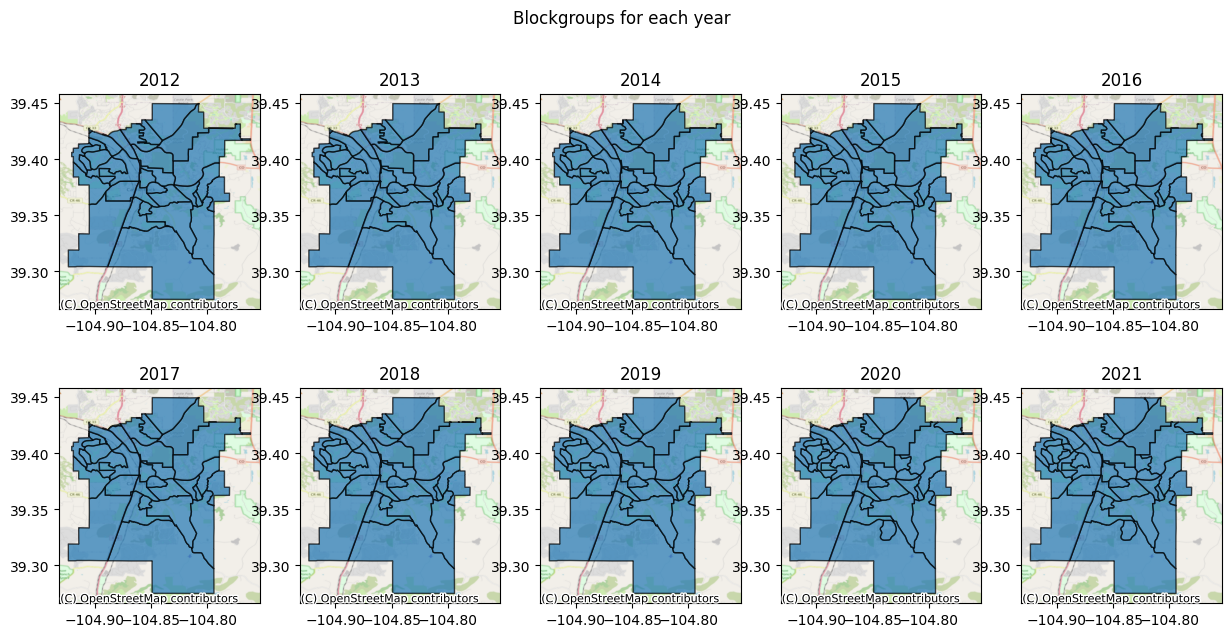

In [81]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,7))
fig.suptitle("Blockgroups for each year")

for i, (shp, ax) in enumerate(zip(list_bgs, axs.ravel())):
  ax2 = shp.plot(ax=ax, alpha=0.7, edgecolor='black')
  cx.add_basemap(ax2, crs=4326, source=cx.providers.OpenStreetMap.Mapnik)
  ax2.set_title(bgs_years[i])

## Dataframes

### Main Dataframe

We first determine the number of calls per block group by counting the incidents within each block group in each year.

In [82]:
incidents_homevalues = incidents_homevalues.rename(columns={'index_right': 'index_before'})

In [83]:
bgs_years = pd.to_numeric(bgs_years)
num_inc_dfs = []
for i, shp in enumerate(list_bgs):
  incidents = incidents_homevalues[incidents_homevalues['incident_year'] == bgs_years[i]]
  incidents_bg = incidents.sjoin(shp, how='left')
  num_inc = incidents_bg[['GEOID', 'incident_year', 'incident_number']]
  num_inc = num_inc.groupby(['GEOID', 'incident_year']).incident_number.count()
  num_inc = num_inc.reset_index()
  num_inc = num_inc.rename(columns={"incident_number":"Number_of_calls", "incident_year":"year"})
  num_inc = num_inc.set_index(['GEOID', 'year'])
  num_inc_dfs.append(num_inc)

In [84]:
num_inc_2 = pd.concat(num_inc_dfs)
num_inc_2

,,Number_of_calls
GEOID,year,
080350140121,2012,200
080350140122,2012,61
080350140123,2012,36
080350140131,2012,77
080350140132,2012,7
...,...,...
080350146031,2021,129
080350146032,2021,116
080350146033,2021,60


Next we find the average home value within each block group for each year.

In [85]:
cols = ['AV_2012','AV_2013','AV_2014','AV_2015','AV_2016','AV_2017','AV_2018','AV_2019','AV_2020','AV_2021']
parcels_fsarea[cols] = parcels_fsarea[cols].apply(pd.to_numeric, axis=1)

In [86]:
parcels_avgval = []
for i, shp in enumerate(list_bgs):
  parc_bg = parcels_fsarea.sjoin(shp, how='left')
  parc_avgval = parc_bg[['GEOID', f'AV_{bgs_years[i]}']]
  parc_avgval = parc_avgval.groupby('GEOID').mean()
  parc_avgval = parc_avgval.rename(columns = {f'AV_{bgs_years[i]}':'avg_homevalue'})
  parc_avgval['year'] = bgs_years[i]
  parc_avgval = parc_avgval.reset_index()
  parc_avgval = parc_avgval.set_index(['GEOID', 'year'])
  parcels_avgval.append(parc_avgval)

In [87]:
parcels_avgval_2 = pd.concat(parcels_avgval)
parcels_avgval_2

,,avg_homevalue
GEOID,year,
080350139091,2012,150183.250000
080350140121,2012,289119.326203
080350140122,2012,270729.147929
080350140123,2012,269802.923767
080350140131,2012,244639.238095
...,...,...
080350146031,2021,488044.218345
080350146032,2021,510943.357550
080350146033,2021,458067.049587


Next, we need to create population density from the population estimate variable we already have. We calculate the area of each block group, by projecting the blockgroups to epsg 2232, which corresponds to the NAD83 Colorado Central (ftUS) projection. This gives us the area in square ft, which is converted to square miles. We then divide the population estimate by the are to get population density.

In [88]:
pop_list = []
pop_df.reset_index(inplace=True)
for i, shp in enumerate(list_bgs[1:]):
  shp = shp.to_crs(epsg=2232)
  shp["area_ft"] = shp['geometry'].area
  shp["area_miles"] = shp["area_ft"]*square_ft2mi
  bg_subset = shp[['GEOID', 'area_miles']]
  pop_subset = pop_df[pop_df['year'] == bgs_years[i+1]]
  pop_subset = pop_subset.merge(bg_subset, how='right', on=['GEOID'])
  pop_subset['pop_est'] = pd.to_numeric(pop_subset['pop_est'])
  pop_subset['pop_density'] = pop_subset['pop_est']/pop_subset['area_miles']
  pop_subset = pop_subset.set_index(['GEOID', 'year'])
  pop_list.append(pop_subset)

In [89]:
pop_df_2 = pd.concat(pop_list)
pop_df_2

,,pop_est,area_miles,pop_density
GEOID,year,,,
080350140132,2013,2433,3.476816,699.778162
080350145031,2013,2263,0.955606,2368.130121
080350146042,2013,1875,1.297171,1445.453564
080350139091,2013,2656,0.046124,57583.366751
080350146031,2013,3112,1.262519,2464.913741
...,...,...,...,...
080350146032,2021,3059,0.712836,4291.309753
080350146033,2021,1537,0.195334,7868.589660
080350144054,2021,1766,0.296951,5947.100130


Finally these dataframes are merged together to get one dataframe with all the variables that we want. We also account for inflation in the average homevalues with the last line of code, but converting previous years pricing to current day dollars.

In [90]:
pop_sub = pop_df_2[['pop_density', 'pop_est']]
old_sub = old_df[['Percent_households_with_65+']]
model_df = parcels_avgval_2.merge(pop_sub, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(num_inc_2, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(old_sub, how='left', on=['GEOID', 'year'])
model_df.reset_index(inplace=True)
model_df['avg_homevalue'] = model_df.apply(lambda x: inflate(x['avg_homevalue'], x['year'], to=2021), axis = 1)

In [91]:
model_df

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
0,080350139091,2012,177248.339471,NaN,NaN,NaN,NaN
1,080350140121,2012,341222.609569,NaN,NaN,200.0,NaN
2,080350140122,2012,319518.267961,NaN,NaN,61.0,NaN
3,080350140123,2012,318425.125452,NaN,NaN,36.0,NaN
4,080350140131,2012,288726.597153,NaN,NaN,77.0,NaN
...,...,...,...,...,...,...,...
350,080350146031,2021,488044.218345,2448.513286,3091.0,129.0,15.487179
351,080350146032,2021,510943.357550,4291.309753,3059.0,116.0,7.560976
352,080350146033,2021,458067.049587,7868.589660,1537.0,60.0,9.810671
353,080350146041,2021,526479.161950,602.387145,2272.0,83.0,15.217391


Because we calculated the area of the blockgroups, certain blockgroups on the edge of our area of study are cut off and have a smaller calculated area than what the actual block group has. Using the population estimate from the census with these incorrect areas caused huge population densities, and so we need to exclude these blockgroups from the data set by filtering them out.

In [92]:
model_df = model_df[model_df['pop_density'] < 20000]
model_df

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
34,080350140121,2013,344706.126856,1375.564201,1792.0,231.0,31.508678
35,080350140122,2013,328142.885112,1310.003867,4177.0,68.0,2.150538
36,080350140123,2013,318879.817841,977.118467,883.0,17.0,8.026756
37,080350140131,2013,297095.492427,287.310682,1641.0,87.0,15.697674
38,080350140132,2013,272272.177751,699.778162,2433.0,6.0,10.428571
...,...,...,...,...,...,...,...
350,080350146031,2021,488044.218345,2448.513286,3091.0,129.0,15.487179
351,080350146032,2021,510943.357550,4291.309753,3059.0,116.0,7.560976
352,080350146033,2021,458067.049587,7868.589660,1537.0,60.0,9.810671
353,080350146041,2021,526479.161950,602.387145,2272.0,83.0,15.217391


### Standarized Dataframe

Below we create a dataframe where we standardize the variables within each year, to examine if the data is stationary over the years.

In [93]:
standard_dfs = []
model_stand = model_df.copy()
for year in bgs_years[1:]:
  model_stand.loc[model_stand['year'] == year, 'avg_homevalue'] = (model_stand.loc[model_stand['year'] == year, 'avg_homevalue'] - model_stand.loc[model_stand['year'] == year, 'avg_homevalue'].mean()) / model_stand.loc[model_stand['year'] == year, 'avg_homevalue'].std()
  model_stand.loc[model_stand['year'] == year, 'pop_density'] = (model_stand.loc[model_stand['year'] == year, 'pop_density'] - model_stand.loc[model_stand['year'] == year, 'pop_density'].mean()) / model_stand.loc[model_stand['year'] == year, 'pop_density'].std()
  model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'] = (model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'] - model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'].mean()) / model_stand.loc[model_stand['year'] == year, 'Percent_households_with_65+'].std()
  model_stand.loc[model_stand['year'] == year, 'Number_of_calls'] = (model_stand.loc[model_stand['year'] == year, 'Number_of_calls'] - model_stand.loc[model_stand['year'] == year, 'Number_of_calls'].mean()) / model_stand.loc[model_stand['year'] == year, 'Number_of_calls'].std()
  standard_dfs.append(model_stand.loc[model_stand['year'] == year])

model_stand = pd.concat(standard_dfs)
model_df

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
34,080350140121,2013,344706.126856,1375.564201,1792.0,231.0,31.508678
35,080350140122,2013,328142.885112,1310.003867,4177.0,68.0,2.150538
36,080350140123,2013,318879.817841,977.118467,883.0,17.0,8.026756
37,080350140131,2013,297095.492427,287.310682,1641.0,87.0,15.697674
38,080350140132,2013,272272.177751,699.778162,2433.0,6.0,10.428571
...,...,...,...,...,...,...,...
350,080350146031,2021,488044.218345,2448.513286,3091.0,129.0,15.487179
351,080350146032,2021,510943.357550,4291.309753,3059.0,116.0,7.560976
352,080350146033,2021,458067.049587,7868.589660,1537.0,60.0,9.810671
353,080350146041,2021,526479.161950,602.387145,2272.0,83.0,15.217391


In [94]:
model_stand

,GEOID,year,avg_homevalue,pop_density,pop_est,Number_of_calls,Percent_households_with_65+
34,080350140121,2013,-0.151415,-0.341787,1792.0,0.962566,1.411046
35,080350140122,2013,-0.274877,-0.373647,4177.0,-0.629527,-1.272946
36,080350140123,2013,-0.343924,-0.535416,883.0,-1.127667,-0.735728
37,080350140131,2013,-0.506303,-0.870634,1641.0,-0.443946,-0.034434
38,080350140132,2013,-0.691335,-0.670192,2433.0,-1.235109,-0.516148
...,...,...,...,...,...,...,...
350,080350146031,2021,-0.419217,-0.153914,3091.0,-0.129050,-0.520597
351,080350146032,2021,-0.334549,0.660996,3059.0,-0.228761,-1.248639
352,080350146033,2021,-0.530056,2.242918,1537.0,-0.658289,-1.041998
353,080350146041,2021,-0.277106,-0.970296,2272.0,-0.481876,-0.545378


In [95]:
pop_sub = pop_df_2[['pop_density', 'pop_est']]
old_sub = old_df[['Percent_households_with_65+']]
model_df = parcels_avgval_2.merge(pop_sub, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(num_inc_2, how='left', on=['GEOID', 'year'])
model_df = model_df.merge(old_sub, how='left', on=['GEOID', 'year'])
model_df.reset_index(inplace=True)
model_df['avg_homevalue'] = model_df.apply(lambda x: inflate(x['avg_homevalue'], x['year'], to=2021), axis = 1)

## Exploratory Data Analysis

### Mapping

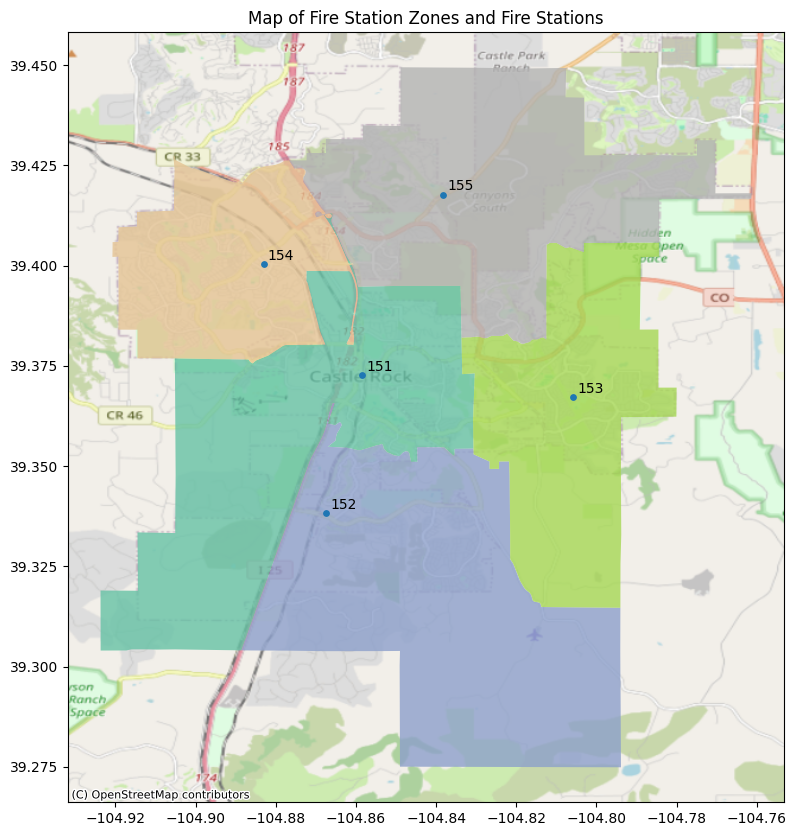

In [96]:
base = fs_zones_gdf.plot(figsize=(10,10), column='STATION', cmap='Set2', alpha=0.8)
base2 = firestations_gdf.plot(ax=base, markersize=15, legend=True)
cx.add_basemap(base2, crs=4326, source=cx.providers.OpenStreetMap.Mapnik)
plt.title("Map of Fire Station Zones and Fire Stations")
for x, y, label in zip(firestations_gdf.geometry.x, firestations_gdf.geometry.y, firestations_gdf.STN_NUMB):
    base2.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

Text(0.5, 1.0, 'All Incidents (2013-2021) by Incident Type')

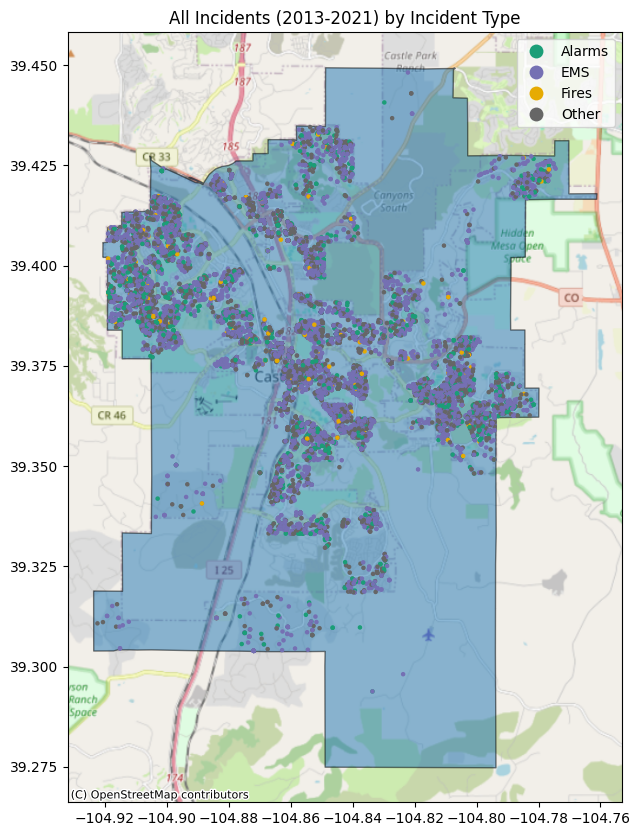

In [97]:
ax = fs_districts_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=4326, source=cx.providers.OpenStreetMap.Mapnik)
inc_hom_na = incidents_homevalues.dropna()
inc_hom_na.plot(ax=ax, column = 'incident_type_category', markersize=5, cmap='Dark2', legend=True)
plt.title("All Incidents (2013-2021) by Incident Type")

### Histograms

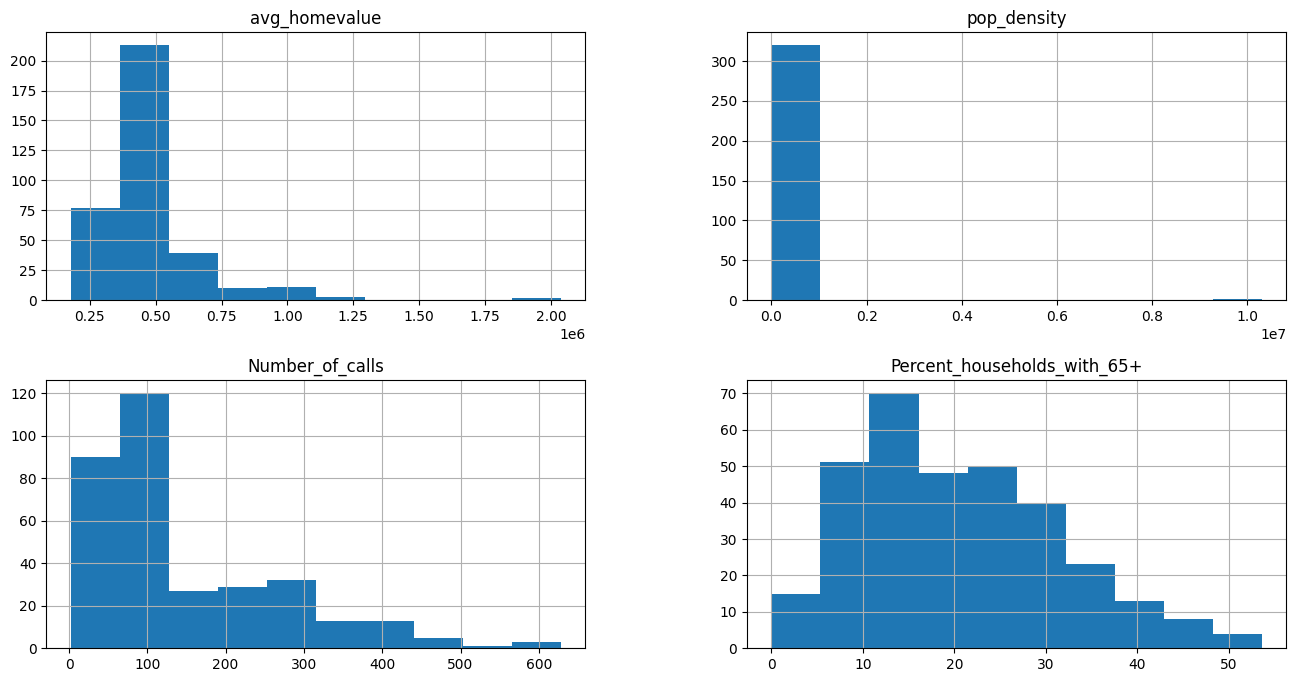

In [98]:
hist_model = model_df.copy()
hist_model = hist_model.drop(columns=['year', 'pop_est'])
histograms = hist_model.hist(figsize=(16,8))

# Conclusion

Words